In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade pip
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece
!pip install tqdm
!pip install cleanlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 13.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 28.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 19.7 MB/s eta 0:00:00
Looking in indexes: 

In [5]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
from tqdm import tqdm

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
print(device)

cuda


https://shivanandroy.com/fine-tune-t5-transformer-with-pytorch/

In [7]:
class CustomDataSetClass(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, dataframe, tokenizer, source_len, target_len, source_text, target_text
    ):
        """
        Initializes a Dataset class

        Args:
            dataframe (pandas.DataFrame): Input dataframe
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = target_len
        self.target_text = self.data[target_text]
        self.source_text = self.data[source_text]

    def __len__(self):
        """returns the length of dataframe"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

In [57]:
import time

def train(epoch, tokenizer, model, device, loader, optimizer):

    """
    Function to be called for training with the parameters passed from main function

    """
    # start_time = time.time()
    model.train()
    losses = []
    print("Epoch:", epoch)
    for i, data in tqdm(enumerate(loader, 0)):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        losses.append(loss.item())
        #if i % 100 == 0:
        #    print("Iteration:", i, "Loss:", loss, "Elapsed time:", time.time()-start_time)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

In [9]:
def validate(epoch, tokenizer, model, device, loader):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

          predictions.extend(preds)
          actuals.extend(target)
  return predictions, actuals

In [29]:
def T5Trainer(
    dataframe, source_text, target_text, model_params, output_dir="./outputs/", model=None, tokenizer=None
):

    """
    T5 trainer

    """

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    print(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # tokenzier for encoding the text
    if tokenizer is None:
      tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if model is None:
      model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    model = model.to(device)

    # Importing the raw dataset
    dataframe = dataframe[[source_text, target_text]]

    # Creation of Dataset and Dataloader
    # Defining the train size. So 60% of the data will be used for training and the rest for validation.
    train_size = 0.6
    train_dataset = dataframe.sample(frac=train_size, random_state=model_params["SEED"])
    val_dataset = dataframe.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print(f"FULL Dataset: {dataframe.shape}")
    print(f"TRAIN Dataset: {train_dataset.shape}")
    print(f"TEST Dataset: {val_dataset.shape}\n")

    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataSetClass(
        train_dataset,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )
    val_set = CustomDataSetClass(
        val_dataset,
        tokenizer,
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
    )

    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=model_params["LEARNING_RATE"], eps=1e-8)
    # optimizer = torch.optim.Adam(
    #     params=model.parameters(), lr=model_params["LEARNING_RATE"]
    # )

    # Training loop
    print(f"[Initiating Fine Tuning]...\n")
    losses = []
    for epoch in range(model_params["TRAIN_EPOCHS"]):
        epoch_losses = train(epoch, tokenizer, model, device, training_loader, optimizer)
        losses.extend(epoch_losses)

    print(f"[Saving Model] to {os.path.join(output_dir, 'model_files')}\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis, res)
    plt.show()

    # evaluating test dataset
    
    print(f"[Initiating Validation]...\n")
    for epoch in range(model_params["VAL_EPOCHS"]):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, "predictions.csv"))
    



Importing dataset

In [11]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [12]:
from datasets import load_dataset

In [13]:
dataset = load_dataset("piqa")

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

Dataset piqa downloaded and prepared to /root/.cache/huggingface/datasets/piqa/plain_text/1.1.0/6c611c1a9bf220943c4174e117d3b660859665baf1d43156230116185312d011. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
dataset['train']

Dataset({
    features: ['goal', 'sol1', 'sol2', 'label'],
    num_rows: 16113
})

In [15]:
dataset['train']['goal'][:10]

["When boiling butter, when it's ready, you can",
 'To permanently attach metal legs to a chair, you can',
 'how do you indent something?',
 'how do you shake something?',
 'Clean tires',
 'how do you taste something?',
 'To create a makeshift ice pack,',
 "What should I use as a stain on a wooden bowl I've just made.",
 'How to boil eggs.',
 'how do you stab something?']

In [16]:
df = pd.DataFrame(dataset['train'])

In [17]:
df["source"] = "question: " + df['goal'] + " context: 1 " + df['sol1'] + ", 2 " + df['sol2']

In [18]:
df["source"][10]

'question: How to quickly soften butter for baking? context: 1 Place the stick of butter inside a freezer bag and beat it with a wooden rolling pin, 2 Place the stick of butter atop a freezer bag and beat it with a wooden rolling pin'

In [53]:
df["target"] = "1"
df.loc[df["label"] == 1, "target"] = "2"

In [54]:
df["target"][:5]

0    2
1    1
2    1
3    1
4    2
Name: target, dtype: object

Fine tuning

In [55]:
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE": 8,  # training batch size
    "VALID_BATCH_SIZE": 16,  # validation batch size
    "TRAIN_EPOCHS": 3,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 4e-5,  # learning rate
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 20,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

In [56]:
T5Trainer(df, "source", "target", model_params)

[Model]: Loading t5-small...



/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depreca

FULL Dataset: (16113, 2)
TRAIN Dataset: (9668, 2)
TEST Dataset: (6445, 2)

[Initiating Fine Tuning]...

Epoch: 0


1209it [05:08,  3.92it/s]


Epoch: 1


1209it [05:16,  3.82it/s]


Epoch: 2


1209it [05:10,  3.90it/s]


[Saving Model] to ./outputs/model_files

[Initiating Validation]...



Test inference

In [23]:
model = T5ForConditionalGeneration.from_pretrained("drive/My Drive/Outputs/model_files")
tokenizer = T5Tokenizer.from_pretrained("drive/My Drive/Outputs/model_files")

In [32]:
model = T5ForConditionalGeneration.from_pretrained("./outputs/model_files")
tokenizer = T5Tokenizer.from_pretrained("./outputs/model_files")

In [33]:
model.save_pretrained("drive/My Drive/Outputs")
tokenizer.save_pretrained("drive/My Drive/Outputs")

('drive/My Drive/Outputs/tokenizer_config.json',
 'drive/My Drive/Outputs/special_tokens_map.json',
 'drive/My Drive/Outputs/spiece.model',
 'drive/My Drive/Outputs/added_tokens.json')

In [24]:
df["source"][100]

'question: Prevent bread from getting soggy in cooler. context: 1 Wrap sandwiches in newspaper., 2 Wrap sandwiches in foil.'

In [25]:
def generate(model, tokenizer, input_sent, max_in=512):
  tokenized_inp = tokenizer.encode_plus(input_sent,  max_length=max_in, pad_to_max_length=True,return_tensors="pt")
  input_ids  = tokenized_inp["input_ids"]
  input_attention_mask = tokenized_inp["attention_mask"]

  model.eval()
  beam_outputs = model.generate(
    input_ids=input_ids,
    attention_mask=input_attention_mask,
    max_length=64,
    early_stopping=True,
    num_beams=12,
    num_return_sequences=1,
    no_repeat_ngram_size=2
  )

  for beam_output in beam_outputs:
      sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      print(sent)

In [26]:
generate(model, tokenizer, df["source"][100])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


2


Testing pipeline with finetuned T5

In [41]:
def rank_nlp_dataset_final(dataset, tokenizer, model, prefix):

    from cleanlab.rank import get_label_quality_scores
    #### Run the model 

    def get_emotion_probs(text):
        with torch.no_grad():
            enc = tokenizer(prefix+text, return_tensors="pt", padding=True)

            decoder_input_ids = torch.tensor([tokenizer.pad_token_id]).unsqueeze(0)
            
            logits = model(**enc, decoder_input_ids=decoder_input_ids)[0]
#             tokens = torch.argmax(logits, dim=2)
#             emotion = tokenizer.batch_decode(tokens)
        return F.softmax(logits,dim=2).squeeze(0)
    
    ## Get pred probs
    pred_probs=[]
    given = []
    for idx in tqdm(range(len(dataset))):
        text,target_emo = dataset[idx]
        pred_probs.append(get_emotion_probs(text)[0])
        given.append(tokenizer.encode(target_emo)[:-1])

        
    ## Prep for cleanlab
    pred_probs = np.stack(pred_probs)
    print(pred_probs.shape)
    given = np.array(given).squeeze()
    print(given.shape)
    ranked_label_issues = get_label_quality_scores(given, pred_probs)
    return ranked_label_issues

In [45]:
smaller_dataset ={}

for i in tqdm(range(500)):
    first = "question: " + dataset['validation']['goal'][i] + " context: 1 " + dataset['validation']['sol1'][i] + ", 2 " + dataset['validation']['sol2'][i]
    smaller_dataset[i] = (first, "1" if dataset['validation']["label"][i] == 0 else "2")

100%|██████████| 500/500 [00:02<00:00, 173.78it/s]


In [46]:
rank3 = rank_nlp_dataset_final(smaller_dataset,tokenizer,model, "")

100%|██████████| 500/500 [00:40<00:00, 12.48it/s]

(500, 32128)
(500,)


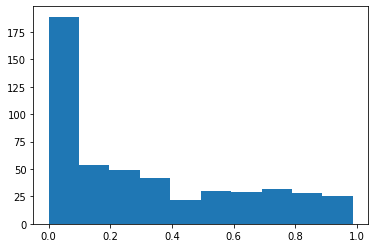

In [47]:
plt.hist(rank3)
plt.show()

In [48]:
np.argsort(rank3)

array([213, 126, 262,  19, 251, 237, 158, 338, 455, 242, 373,  15, 396,
       329,  51,  13, 218, 208, 275, 195, 423, 260, 307,   8, 292, 164,
       219, 203, 192,  96, 482, 153,  53, 263,  61, 300, 397, 293,  22,
       216, 334,  20,  68,  55,  16, 246,  17,  23, 316, 233, 271, 347,
       130, 270,  89, 155, 332, 357, 122, 152, 185, 248, 210,  33,  35,
       154, 424,  52, 277, 274, 226, 454, 108, 480, 188, 346, 351, 461,
       308, 220, 127,  47, 476, 170, 142, 145, 100, 101, 171, 301, 162,
        86, 345, 475,   4, 393, 207,  59, 352, 276, 200, 128, 362,  76,
       348, 113, 376, 414, 268, 133, 430, 404, 173, 194,  65, 413, 366,
       190, 179,   9, 447, 183,  79,  50,  83, 180,  84, 148, 239, 147,
        58, 409, 349,  21, 169, 309, 473, 415,  98, 206, 238, 372, 433,
       166,  45,  34, 323, 335, 434, 135, 109, 140, 175, 167, 222, 176,
       387, 490, 460, 313, 236,  25, 327, 134, 428, 459, 243, 488, 121,
       431, 191, 439,  67, 492, 297, 398, 182, 406, 201, 353, 40

In [50]:
smaller_dataset[126]

('question: How can I get more use out of my utility knife? context: 1 When the blade in your utility knife gets dull, it’s usually only the point and the first 1/4 in. or so that’s bad and you can get additional life from your blade by snapping off the point with a pliers (wear safety glasses) it won’t cut quite as well as a fresh blade, but a lot better than the dull one., 2 When the blade in your utility knife gets dull, it’s usually only the point and the first 1/4 in. or so that’s bad and you can get additional life from your blade by snapping off the point with a bare finger (wear safety glasses) it won’t cut quite as well as a fresh blade, but a lot better than the dull one.',
 '1')

In [52]:
generate(model, tokenizer, smaller_dataset[126][0])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


snapping
